# Load data

This notebook will apply EOF analysis to regridded V20 SSH data via a Jupyter Notebook using ferretmagic.  Many thanks to Patrick Brockmann and the [ferretmagic documentation](https://github.com/PBrockmann/C-CASCADES_notebooks/blob/master/ferretBasics.ipynb) for providing an excellent starting point!  Also thanks to the Ferret Development Team for their [EOF example](https://ferret.pmel.noaa.gov/Ferret/documentation/ferret-eof-demo).  More details on the EOFSVD code are [here](https://ferret.pmel.noaa.gov/Ferret/documentation/users-guide/appendix-a-external-functions/EOF-SPACE#_eofsvd_space).  First we start ferretmagic and then load the data into PyFerret.

# Some thoughts on computational resources

With 1 degree, monthly data, 1958-2009, we're using about 1.5GB RAM (.9GB app + 0.6GB baseline), runs in a few minutes.  Going to 0.5 degree, we'd quadruple the data (double in each x,y direction) => 0.9 x 4 = 3.6GB + 0.6GB estimate.  Going to 0.25 degree, quadruple again => 3.6 x 4 = 14.4GB + 0.6.  That doesn't count container baseline RAM.

In [1]:
%load_ext ferretmagic

In [2]:
%%ferret

cancel data/all
!use /home/jovyan/data/1_mesh_mask.nc
!use /home/jovyan/data/V20_1948_2009_SSH.nc
use /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_monthly.nc
use /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_annual.nc
!use coads_climatology
!use V20_1958_2009_SSH_regridded.nc
set memory /size=2000
show data


currently SET data sets:
 1> /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_monthly.nc
 name title I J K L
 TIME ... ... ... 1:624
 (invalid coordinate axis)
 SSH 1:89 1:85 ... 1:624
 GLAMT 1:89 1:85 ... ...
 GPHIT 1:89 1:85 ... ...
 
 2> /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_annual.nc (default)
 name title I J K L
 TIME ... ... ... 1:52
 (invalid coordinate axis)
 SSH 1:89 1:85 ... 1:52
 GLAMT 1:89 1:85 ... ...
 GPHIT 1:89 1:85 ... ...

# Sample plot of data

! Enter_GO land
! Exit_GO


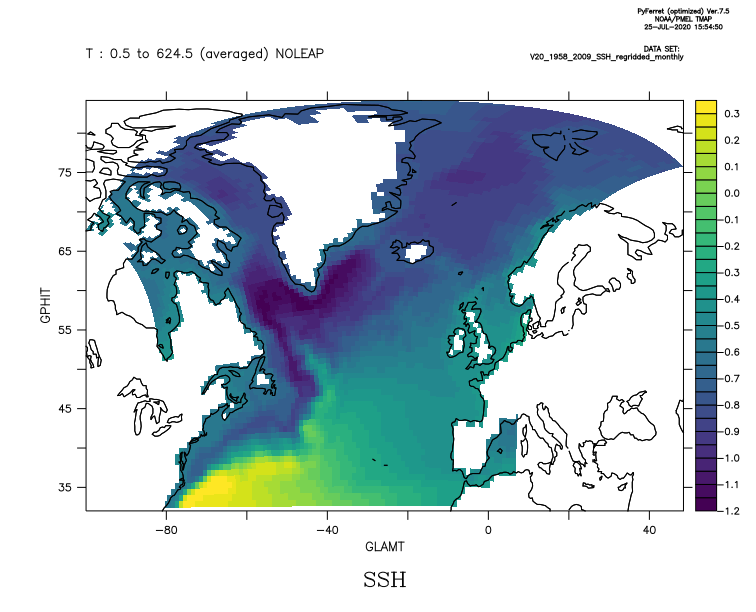

In [8]:
%%ferret
shade /i=2:2000 /j=2:2000 ssh[d=1,l=@AVE],glamt[d=1],gphit[d=1]; go land

Find the difference between the true (uniform weighted)
mean of all 5-day snapshots and the mean of all months
(with the last month having 7 5-day intervals instead of
6 5-day intervals in the other months.)

The result is within \[-0.065,0.04\] m or within 10% over
most of the domain.  The biggest deviations are over the
Gulf Stream.

In [ ]:
%%ferret
shade /i=2:2000 /j=2:2000 /levels=(-inf)(-10,10,1)(inf) 100*(ssh[d=1,l=@AVE]-ssh[d=2,l=@AVE])/ssh[d=1,l=@AVE],glamt,gphit; go land

# Run EOF

In [ ]:
%%ferret
let ssh_anom = ssh[d=1]-ssh[d=1,l=@AVE]
let eof_time = eofsvd_tfunc(ssh_anom)
save /clobber /file=eof_time.nc eof_time


In [ ]:
%%ferret
let eof_space = eofsvd_space(ssh_anom)
save /clobber /file=eof_space.nc eof_space


In [ ]:
%%ferret
let eof_stat = eofsvd_stat(ssh_anom)
save /clobber /file=eof_stat.nc eof_stat


In [3]:
%%ferret
use eof_time.nc
use eof_space.nc
use eof_stat.nc
sh d

currently SET data sets:
 1> /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_monthly.nc
 name title I J K L
 TIME ... ... ... 1:624
 (invalid coordinate axis)
 SSH 1:89 1:85 ... 1:624
 GLAMT 1:89 1:85 ... ...
 GPHIT 1:89 1:85 ... ...
 
 2> /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_annual.nc
 name title I J K L
 TIME ... ... ... 1:52
 (invalid coordinate axis)
 SSH 1:89 1:85 ... 1:52
 GLAMT 1:89 1:85 ... ...
 GPHIT 1:89 1:85 ... ...
 
 3> ./eof_time.nc
 name title I J K L
 TIME ... ... ... 1:624
 (invalid coordinate axis)
 EOF_TIME EOFSVD_TFUNC(SSH_ANOM) 1:7565 ... ... 1:624
 (T=0.5:624.5)
 
 4> ./eof_space.nc
 name title I J K L
 EOF_SPACE
 EOFSVD_SPACE(SSH_ANOM) 1:89 1:85 ... 1:7565
 
 5> ./eof_stat.nc (default)
 name title I J K L
 EOF_STAT EOFSVD_STAT(SSH_ANOM) 1:7565 1:3 ... ...

In [4]:
%%ferret
! List the percent variance explained for each EOF
list eof_stat[d=5,i=1:10,j=2]


VARIABLE : EOFSVD_STAT(SSH_ANOM)
 FILENAME : eof_stat.nc
 SUBSET : 10 points (X)
 Y : 2
 2 
 2
 1 / 1: 31.10
 2 / 2: 5.83
 3 / 3: 5.16
 4 / 4: 3.90
 5 / 5: 2.66
 6 / 6: 2.08
 7 / 7: 1.81
 8 / 8: 1.71
 9 / 9: 1.46
 10 / 10: 1.42

# Initial thoughts and interpretation

1. EOF 1 -> highly seasonal, next to no long term variability.  I interpret this as the seasonal spin-up and spin-down of eddy driven recirculations due to increased/decreased impact of the wind forcing.  Would make for a great paper, is this in the observational data too?  Perhaps the HR data is too short to pick this up?

2. EOF 2 -> Similar to SPG index in spatial map, but the time series is different.

3. EOF 3 -> Highly seasonal, low long term variability (like EOF1) which has basin-interior changes in SSH (poles on shelves and over Gulf Stream -> Tal Ezer's work).

4. EOF 4 -> Probably the closest to the "SPG index" in terms of spatial map and time series.

5. EOF 5 -> Some interesting interannual variability, possibly Gulf Stream strength.

! Enter_GO land
! Exit_GO


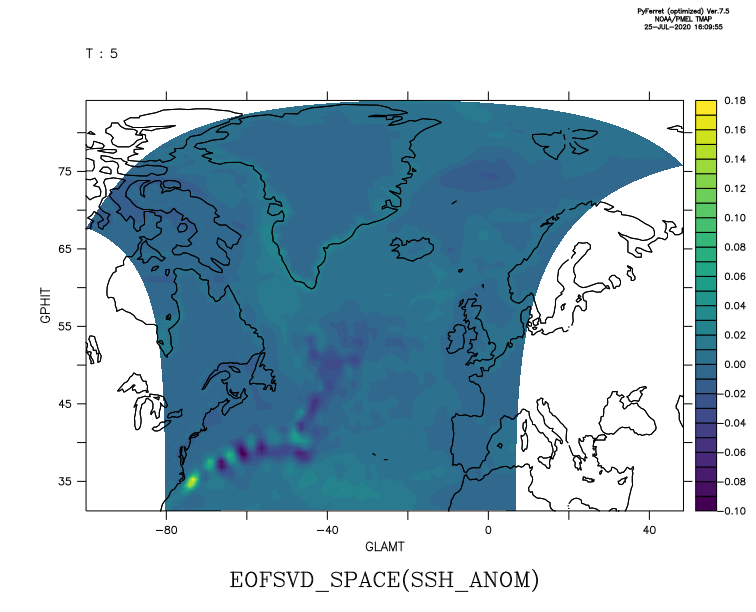

In [27]:
%%ferret
fill eof_space[d=4,l=5],glamt[d=1],gphit[d=1]; go land


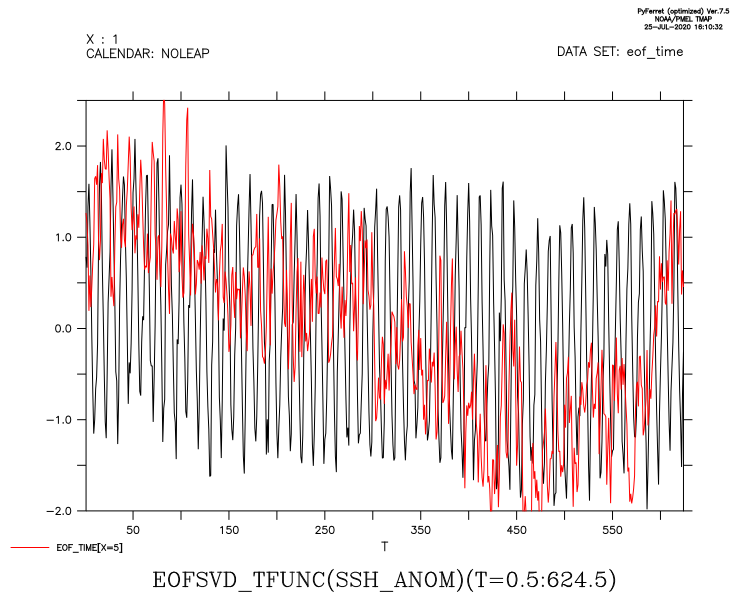

In [28]:
%%ferret
plot eof_time[d=3,i=1]
plot /over /color=2 eof_time[d=3,i=5]

# Copied lines from the Ferret development team's demo to verify output

In [ ]:
%%ferret
let eof_xyfcn = eofsvd_space(sst[X=67w:1w,Y=11S:11N])

set view ul; fill/l=1/TITLE="eof 1" eof_xyfcn; go land
set view ur; fill/l=2/TITLE="eof 2" eof_xyfcn; go land
set view ll; fill/l=3/TITLE="eof 3" eof_xyfcn; go land



In [ ]:
%%ferret
LET eofstat = EOFSVD_STAT(sst[X=67w:1w,Y=11S:11N])
list eofstat[j=2]